# Experiment Iterative Quantum Amplitude Estimatio Parallelization

In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

from multivariateGCI_mr import MultivariateGCI_mr
from multivariateGCI_sr import MultivariateGCI_sr

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, IBMQ, transpile, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem, AmplitudeEstimation
#from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import LinearAmplitudeFunction, QFT
from qiskit.circuit.library import LinearAmplitudeFunction

In [2]:
df = pd.read_csv("Data/sampled_counterparts.csv")
# df = df[((df['pd']>=0.1) & ((1000 < df['lgd dwt']*df['ead']) & (df['lgd dwt']*df['ead'] < 5000000)))]
df =  df.iloc[[38-2, 260-2]] #df.iloc[[38-2, 260-2, 7816-2]] 

F_matrix = pd.read_csv("Data/F_for_sampled_counterparts.csv")
sectors = [1] #[1, 2]
F_values = [[F_matrix.iloc[df.index.values[j]][i-1] for i in sectors] for j in range(len(df))]
# F_values = [[0.55], [0.65], [0.50]] # make F/rhos

## Parameter Setting

In [3]:
# set problem parameters
n_z = 2
z_max = 2

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

K = len(p_zeros)

alpha_var = 0.05

compute_depth = False
serialization = False

print(f'F: {F_values}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')
df

F: [[0.1580707722], [0.2555327991]]
Rhos: [0.3 0.3]
Lgds: [18406.56224845756, 54807.94141703075]
p_zeros: [0.2565108504, 0.0715568886]


,cluster,pd,lgd dwt,ead,num ctp,sett,is,acca,cod type,cod stato,lgd pag
36,005118_618,0.256511,0.223071,82514.537908,83292,5,0.3,0.000083,0,0,0.187699
258,002116_18,0.071557,0.194311,282063.242107,888,2,0.3,0.019318,0,0,0.157672


In [4]:
# Encoding of the uncertainty model

u = MultivariateGCI_mr(n_z, z_max, p_zeros, rhos, F_values)

In [5]:
def mapping(decimal_number):
    b = ('{0:0%sb}' % K).format(decimal_number)
    #print(b)
    losses = [loss for i, loss in enumerate(lgd[::-1]) if b[i]=='1']
    #print(losses)
    total_loss = sum(losses)
    return total_loss

def find_breakpoint(x_eval):
    for el in range(0,2**K):
        if mapping(el) <= x_eval:
            if mapping(el+1) >= x_eval:
                return el
    return 0

depth = 'e_loss'

if depth == 'e_loss':
    # define linear objective function for expected loss
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    offsets = [mapping(el) for el in breakpoints]
    f_min = 0
    f_max = sum(lgd)
    c_approx = 0.01


    objective_e_loss = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

In [6]:
def get_cdf_circuit(x_eval):
    
    # define linear objective function for cdf
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    # print(values)
    offsets = [1 if mapping(el)<=x_eval else 0 for el in breakpoints]
    f_min = 0
    f_max = 1
    c_approx = 0.01
    
    objective = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)

    # linear objective function (does aggregation and comparison)
    if depth == 'e_loss':
        state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective_e_loss
    else:
        state_preparation.append(objective.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective
    

In [7]:
example = 0
state_preparation, objective = get_cdf_circuit(example)

In [8]:
state_preparation.draw()

┌───────┐      
  state_0: ┤0      ├──────
           │       │      
  state_1: ┤1      ├──────
           │  P(X) │┌────┐
  state_2: ┤2      ├┤0   ├
           │       ││    │
  state_3: ┤3      ├┤1   ├
           └───────┘│    │
objective: ─────────┤2 F ├
                    │    │
   work_0: ─────────┤3   ├
                    │    │
   work_1: ─────────┤4   ├
                    └────┘

In [9]:
# set target precision and confidence level
epsilon = 0.01/6
alpha = 0.05/6

simulated = True
optimization_level = 1
n_shots = 10000

qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)


#coupling_map = backend.configuration().coupling_map
#basis_gates = noise_model.basis_gates

#qi_noise = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
#                        optimization_level=optimization_level, seed_transpiler=42,
#                        noise_model=noise_model, basis_gates=basis_gates, coupling_map=coupling_map)

problem = EstimationProblem(state_preparation=state_preparation,
                            objective_qubits=[u.num_qubits],
                            post_processing=objective.post_processing)

In [10]:
def get_parallelized_iqae_circuit(iterations,u, objective, K=2,):
    
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    qr_state2 = QuantumRegister(u.num_qubits, 'state_2')
    qr_obj2 = QuantumRegister(1, 'objective_2')
    ar2 = QuantumRegister(objective.num_ancillas, "work_2")  # additional qubits

    qr_eval = QuantumRegister(1, 'eval')
    qr_eval2 = QuantumRegister(1, 'eval_2')

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, qr_eval, qr_state2, qr_obj2, ar2, qr_eval2, name='A')

    # load the random variable
    # state_preparation.append(u.to_gate(), qr_state)
    state_preparation.append(u.to_gate(), qr_state2)

    # state_preparation.cx(qr_result[0], qr_eval[0])
    state_preparation.h(qr_eval2[0])
    # state_preparation.h(qr_eval[0])

    # linear objective function (does aggregation and comparison)
    # state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
    state_preparation.append(objective_e_loss.to_gate(), qr_state2[-K:] + qr_obj2[:] + ar2[:])
    #state_preparation.cx(qr_eval2[-1], qr_eval[-1])
    # state_preparation.append(problem.grover_operator.to_gate(), qr_state[:] + qr_obj[:] + ar[:])
    
    # state_preparation.compose(grover_op.power(2**(3)).control(), qubits=qr_eval[:]+qr_state[:] + qr_obj[:] + ar[:], inplace=True)
    
    state_preparation.compose(grover_op.power(iterations).control(), qubits=qr_eval2[:]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    # state_preparation.cx(qr_eval2[-1], qr_eval[-1])
    state_preparation.h(qr_eval2[0])
    # state_preparation.h(qr_eval[0])
    # state_preparation.append(qpe.to_gate(), qr_eval[:] + qr_state2[:] + qr_obj2[:] + ar2[:])
    # state_preparation.cx(qr_result[0], qr_result[0])
    cr = ClassicalRegister(1)
    state_preparation.add_register(cr)
    state_preparation.measure(qr_eval2[:], [0])

    return state_preparation, objective_e_loss

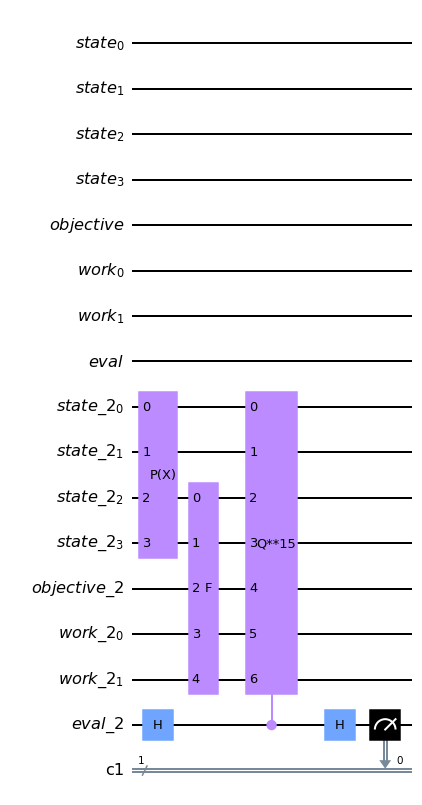

In [12]:
grover_op = problem.grover_operator

state_preparation3, objective = get_parallelized_iqae_circuit(15, u, objective_e_loss)
state_preparation3.draw('mpl')

### Results

In [13]:
mode = 'parallel'
k = 12

df = pd.DataFrame()
for i in range(5):

    state_preparation3, objective = get_parallelized_iqae_circuit(i, u, objective_e_loss)
    counts = qi_ideal.execute(state_preparation3).get_counts(state_preparation3)

    one_counts = 0
    for state, count in counts.items():
        if problem.is_good_state(state):
            one_counts += count
    #iqae_ideal_result = one_counts / sum(counts.values())
    df = df.append({'iterations':i, 'P_1':one_counts}, ignore_index=True)

<AxesSubplot:xlabel='iterations'>

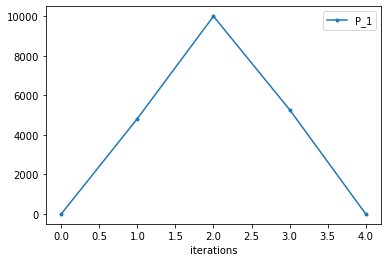

In [14]:
df.set_index('iterations').plot(style='.-')

In [16]:
mode = 'sequential'
sequential_k = 14

df_s = pd.DataFrame()
for i in range(5):
    iqae = IterativeAmplitudeEstimation(epsilon_target=0.01, alpha=0.1, quantum_instance=qi_ideal)
    iqae_circuit = iqae.construct_circuit(problem, k=i, measurement=True)

    counts = qi_ideal.execute(iqae_circuit).get_counts(iqae_circuit)

    one_counts = 0
    for state, count in counts.items():
        if problem.is_good_state(state):
            one_counts += count
    df_s = df_s.append({'iterations':i, 'P_1':one_counts}, ignore_index=True)

<AxesSubplot:xlabel='iterations'>

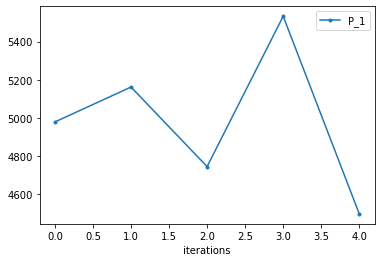

In [17]:
df_s.set_index('iterations').plot(style='.-')

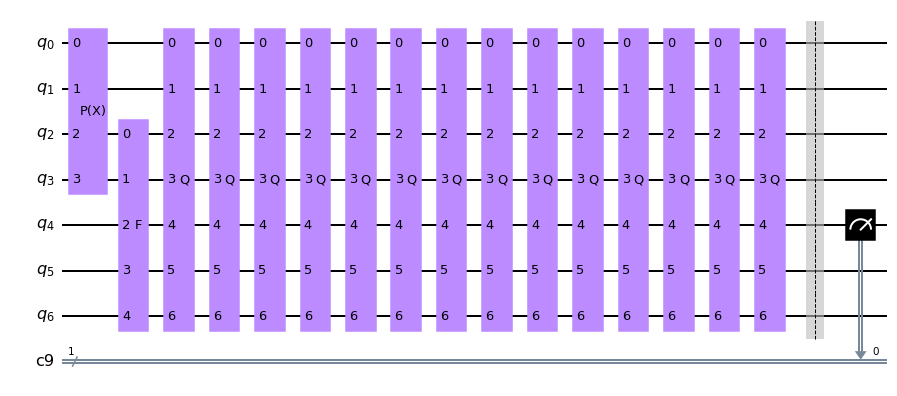

In [28]:
iqae_circuit.decompose().draw("mpl")

In [18]:
df_tot = df.merge(df_s, left_on='iterations',right_on='iterations',suffixes=('_parallel','_sequential'))

In [19]:
df_tot = df_tot[['iterations','P_1_parallel', 'P_1_sequential']]

In [20]:
df_tot['diff'] = df_tot.eval(" P_1_parallel - P_1_sequential ")

<AxesSubplot:>

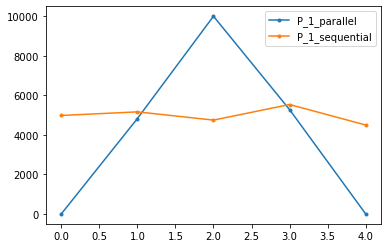

In [21]:
df_tot[['P_1_parallel', 'P_1_sequential']].plot(style='.-')

In [22]:
df_tot

,iterations,P_1_parallel,P_1_sequential,diff
0,0.0,0.0,4979.0,-4979.0
1,1.0,4822.0,5162.0,-340.0
2,2.0,9998.0,4745.0,5253.0
3,3.0,5276.0,5533.0,-257.0
4,4.0,2.0,4497.0,-4495.0
